# PROJECT LUNG DISEASES

## REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization, TimeDistributed, Bidirectional, LSTM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

## DATA PREP

### Initiation Directory

In [2]:
#Path dataset
BASE_DIR = '/kaggle/input/penyakit-paru-paru-5-kelas'

#Path train, test, dan validation
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

### Datagenerator

In [3]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16,
    shuffle= True
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 8
)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [4]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet',
                        include_top=False, 
                        input_shape=(224, 224, 3))
for layer in resnet_model.layers:
    layer.trainable = True
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(Flatten())
model_resnet.add(Dense(100,activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(100,activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(5, 
                       activation='softmax'))
print(model_resnet.summary())

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               10035300  
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________

In [4]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [6]:
model_resnet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

history = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30, 
    verbose=1, 
    callbacks=[reduce_lr, 
               early_stopping]
)

Epoch 1/30
380/380 [==============================] - 104s 225ms/step - loss: 0.6315 - acc: 0.7768 - val_loss: 9.3460 - val_acc: 0.1426
Epoch 2/30
380/380 [==============================] - 77s 203ms/step - loss: 0.2200 - acc: 0.9276 - val_loss: 4.8104 - val_acc: 0.1701
Epoch 3/30
380/380 [==============================] - 77s 203ms/step - loss: 0.2518 - acc: 0.9294 - val_loss: 0.2891 - val_acc: 0.9073
Epoch 4/30
380/380 [==============================] - 77s 203ms/step - loss: 0.1510 - acc: 0.9531 - val_loss: 0.1751 - val_acc: 0.9633
Epoch 5/30
380/380 [==============================] - 77s 203ms/step - loss: 0.1228 - acc: 0.9651 - val_loss: 0.1917 - val_acc: 0.9460
Epoch 6/30
380/380 [==============================] - 77s 203ms/step - loss: 0.0773 - acc: 0.9771 - val_loss: 0.0596 - val_acc: 0.9796
Epoch 7/30
380/380 [==============================] - 77s 203ms/step - loss: 0.0529 - acc: 0.9854 - val_loss: 0.4198 - val_acc: 0.8686
Epoch 8/30
380/380 [==============================] - 

In [ ]:
#model_resnet.save("resnet_model.h5")
#with open('history_resnet.txt', mode='w') as file:
#    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
#    file.close()

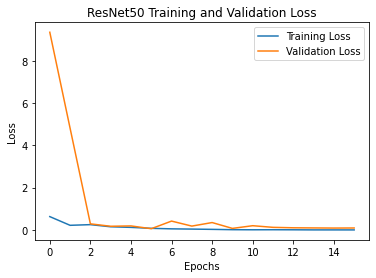

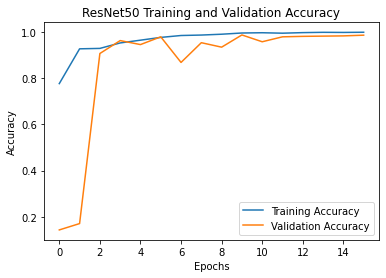

In [7]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
results_val = model_resnet.evaluate(val_generator)
results_train = model_resnet.evaluate(train_generator)
print("Val Loss:", results_val[0])
print("Val Accuracy:", results_val[1])
print("Train Loss:", results_train[0])
print("Train Accuracy:", results_train[1])

380/380 [==============================] - 28s 73ms/step - loss: 0.0157 - acc: 0.9949
Val Loss: 0.05960385873913765
Val Accuracy: 0.9796333909034729
Train Loss: 0.015715865418314934
Train Accuracy: 0.9949012994766235


In [9]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nResNet50 Training classification report:\n", train_class_report)



380/380 [==============================] - 28s 71ms/step

ResNet50 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19673   0.19754   0.19714      1220
            covid19    0.22426   0.22607   0.22516      1243
             normal    0.21440   0.21215   0.21327      1235
       tuberculosis    0.19145   0.19145   0.19145      1170
    viral_pneumonia    0.19835   0.19802   0.19818      1212

           accuracy                        0.20526      6080
          macro avg    0.20504   0.20505   0.20504      6080
       weighted avg    0.20526   0.20526   0.20526      6080



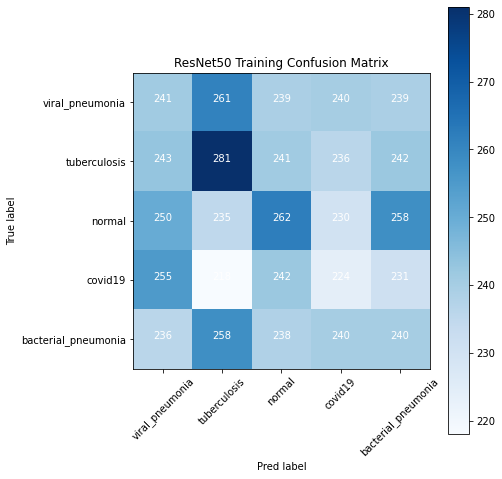

In [10]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("ResNet50 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [5]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = True
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(Flatten())
model_VGG19.add(Dense(100,activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(100,activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2508900   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________

In [6]:
# Compile model
model_VGG19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

history_VGG19 = model_VGG19.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30, 
    verbose=1, 
    callbacks=[reduce_lr, 
               early_stopping]
)

Epoch 1/30
380/380 [==============================] - 121s 278ms/step - loss: 1.2917 - acc: 0.4265 - val_loss: 0.9994 - val_acc: 0.5967
Epoch 2/30
380/380 [==============================] - 100s 262ms/step - loss: 0.9522 - acc: 0.5847 - val_loss: 0.6898 - val_acc: 0.7088
Epoch 3/30
380/380 [==============================] - 100s 263ms/step - loss: 0.7921 - acc: 0.6600 - val_loss: 0.5624 - val_acc: 0.7566
Epoch 4/30
380/380 [==============================] - 100s 263ms/step - loss: 0.6806 - acc: 0.7176 - val_loss: 0.5854 - val_acc: 0.7587
Epoch 5/30
380/380 [==============================] - 100s 262ms/step - loss: 0.5684 - acc: 0.7623 - val_loss: 0.3366 - val_acc: 0.8737
Epoch 6/30
380/380 [==============================] - 100s 262ms/step - loss: 0.5290 - acc: 0.7766 - val_loss: 0.2926 - val_acc: 0.8951
Epoch 7/30
380/380 [==============================] - 100s 262ms/step - loss: 0.4251 - acc: 0.8321 - val_loss: 0.2524 - val_acc: 0.9094
Epoch 8/30
380/380 [============================

In [ ]:
# model_VGG19.save("VGG19_model_skenario1.h5")
# with open('history_VGG19.txt', mode='w') as file:
#    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
#    file.close()

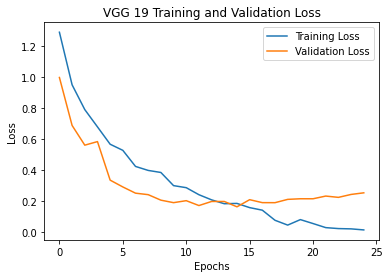

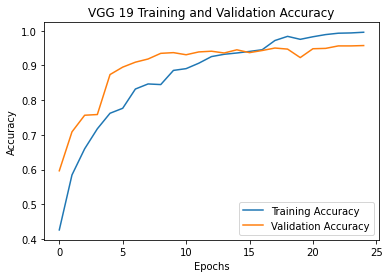

In [7]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('VGG 19 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG 19 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
results_val = model_VGG19.evaluate(val_generator)
results_train = model_VGG19.evaluate(train_generator)
print("Val Loss:", results_val[0])
print("Val Accuracy:", results_val[1])
print("Train Loss:", results_train[0])
print("Train Accuracy:", results_train[1])

380/380 [==============================] - 29s 77ms/step - loss: 0.1087 - acc: 0.9609
Val Loss: 0.16423730552196503
Val Accuracy: 0.9450101852416992
Train Loss: 0.10870208591222763
Train Accuracy: 0.96085524559021


In [9]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nVGG 19 Training classification report:\n", train_class_report)



380/380 [==============================] - 28s 73ms/step

VGG 19 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.23327   0.21721   0.22496      1220
            covid19    0.21582   0.20193   0.20865      1243
             normal    0.20900   0.22186   0.21524      1235
       tuberculosis    0.20719   0.20684   0.20701      1170
    viral_pneumonia    0.20123   0.21617   0.20843      1212

           accuracy                        0.21283      6080
          macro avg    0.21330   0.21280   0.21286      6080
       weighted avg    0.21337   0.21283   0.21290      6080



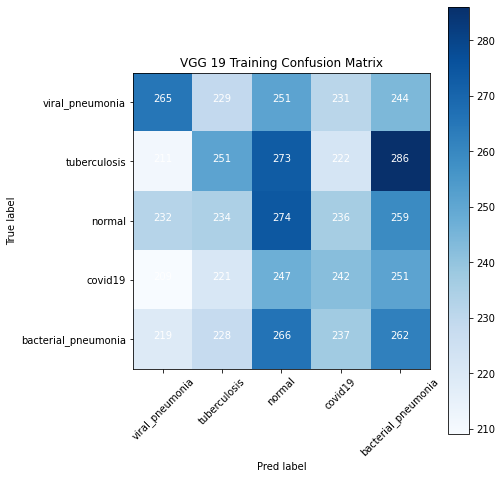

In [10]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("VGG 19 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [11]:
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = True
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(100,activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(100,activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_InceptionV3.summary())

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5120100   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_______________________________________________________

In [12]:
# Compile model
model_InceptionV3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator#,
    #callbacks=callback,
)

Epoch 1/30
380/380 [==============================] - 67s 154ms/step - loss: 0.7552 - acc: 0.7053 - val_loss: 0.3186 - val_acc: 0.8859
Epoch 2/30
380/380 [==============================] - 56s 147ms/step - loss: 0.3614 - acc: 0.8697 - val_loss: 0.1753 - val_acc: 0.9409
Epoch 3/30
380/380 [==============================] - 56s 147ms/step - loss: 0.2268 - acc: 0.9219 - val_loss: 0.1610 - val_acc: 0.9420
Epoch 4/30
380/380 [==============================] - 56s 148ms/step - loss: 0.1836 - acc: 0.9441 - val_loss: 0.1526 - val_acc: 0.9542
Epoch 5/30
380/380 [==============================] - 56s 147ms/step - loss: 0.1165 - acc: 0.9643 - val_loss: 0.1384 - val_acc: 0.9572
Epoch 6/30
380/380 [==============================] - 56s 147ms/step - loss: 0.0875 - acc: 0.9722 - val_loss: 0.1429 - val_acc: 0.9562
Epoch 7/30
380/380 [==============================] - 56s 147ms/step - loss: 0.0653 - acc: 0.9789 - val_loss: 0.1626 - val_acc: 0.9552
Epoch 8/30
380/380 [==============================] - 5

In [ ]:
#model_InceptionV3.save("InceptionV3_model.h5")
#with open('history_InceptionV3.txt', mode='w') as file:
#    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
#    file.close()

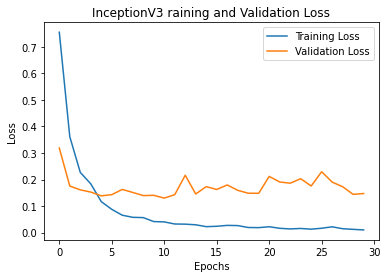

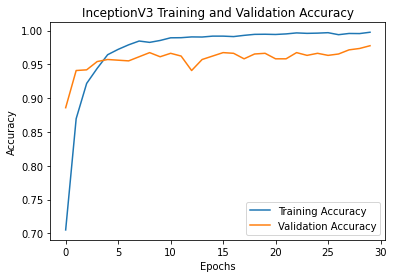

In [13]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 raining and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
results_val = model_InceptionV3.evaluate(val_generator)
results_train = model_InceptionV3.evaluate(train_generator)
print("Val Loss:", results_val[0])
print("Val Accuracy:", results_val[1])
print("Train Loss:", results_train[0])
print("Train Accuracy:", results_train[1])

380/380 [==============================] - 26s 68ms/step - loss: 8.0181e-04 - acc: 0.9995
Val Loss: 0.14712916314601898
Val Accuracy: 0.9775967597961426
Train Loss: 0.0008018050575628877
Train Accuracy: 0.9995065927505493


In [15]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nInceptionV3 Training classification report:\n", train_class_report)



380/380 [==============================] - 27s 67ms/step

InceptionV3 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19885   0.19836   0.19860      1220
            covid19    0.23009   0.23009   0.23009      1243
             normal    0.20891   0.20891   0.20891      1235
       tuberculosis    0.19829   0.19829   0.19829      1170
    viral_pneumonia    0.20000   0.20050   0.20025      1212

           accuracy                        0.20740      6080
          macro avg    0.20723   0.20723   0.20723      6080
       weighted avg    0.20740   0.20740   0.20740      6080



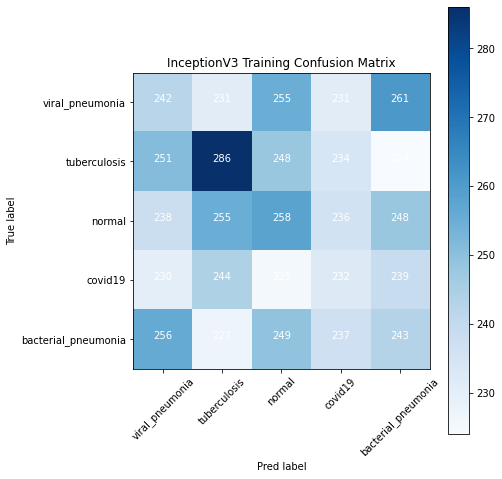

In [16]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("InceptionV3 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()